# 🛒 Product Recommendation System v2.0
---
**Cleaned & Optimized Version**

This notebook builds a semantic product search engine using:
- **TF-IDF Vectorization** for text representation
- **KMeans Clustering** for product grouping  
- **NearestNeighbors** for similarity search

### Pipeline Overview:
1. Data Loading
2. Data Cleaning
3. Feature Engineering
4. Exploratory Data Analysis
5. Text Vectorization
6. Clustering
7. Search Engine
8. Evaluation


In [1]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
# === IMPORTS & CONFIGURATION ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import joblib
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from IPython.display import display

# Configuration
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded successfully")

✅ Libraries loaded successfully


## 1. Data Loading

In [3]:
# Update this path to your data file
DATA_PATH = "/kaggle/input/amazon-canada-products-2023-2-1m-products/amz_ca_total_products_data_processed.csv"

df_original = pd.read_csv(DATA_PATH)
df = df_original.copy()

print(f"Loaded {len(df):,} rows × {len(df.columns)} columns")
print(f"Columns: {list(df.columns)}")

✅ Loaded 2,165,926 rows × 11 columns
Columns: ['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price', 'listPrice', 'categoryName', 'isBestSeller', 'boughtInLastMonth']


In [4]:
df.info()
print("\n" + "="*50)
df.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2165926 entries, 0 to 2165925
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   asin               object 
 1   title              object 
 2   imgUrl             object 
 3   productURL         object 
 4   stars              float64
 5   reviews            int64  
 6   price              float64
 7   listPrice          float64
 8   categoryName       object 
 9   isBestSeller       bool   
 10  boughtInLastMonth  int64  
dtypes: bool(1), float64(3), int64(2), object(5)
memory usage: 167.3+ MB



,stars,reviews,price,listPrice,boughtInLastMonth
count,2165926.00,2165926.00,2165926.00,2165926.00,2165926.00
mean,2.62,545.74,111.22,4.65,9.00
std,2.15,4355.22,497.67,29.84,98.38
min,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,15.42,0.00,0.00
50%,4.00,5.00,27.42,0.00,0.00
75%,4.50,123.00,57.50,0.00,0.00
max,5.00,868865.00,40900.00,999.99,20000.00


## 2. Data Cleaning
- Remove unnecessary columns
- Handle missing values
- Remove duplicates
- Filter invalid prices

In [5]:
# Missing Values Analysis
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0])

       Count  Percentage
title      6    0.000277


In [6]:
# Drop unnecessary columns
cols_to_drop = ["productURL", "listPrice", "boughtInLastMonth"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# Remove missing values
initial_rows = len(df)
df = df.dropna()
print(f"Removed {initial_rows - len(df):,} rows with missing values")

# Remove duplicates
dup_count = df.duplicated(subset=['asin']).sum()
df = df.drop_duplicates(subset=['asin'], keep='first')
print(f"Removed {dup_count:,} duplicate ASINs")

# Filter invalid prices
zero_prices = len(df[df['price'] == 0])
df = df[df['price'] > 0].copy()
print(f"Removed {zero_prices:,} items with $0 price")

print(f" Clean dataset: {len(df):,} rows remaining")

Removed 6 rows with missing values
Removed 0 duplicate ASINs
Removed 177,910 items with $0 price

✅ Clean dataset: 1,988,010 rows remaining


## 3. Feature Engineering
- Super category mapping
- Log transformations
- Text cleaning

In [8]:
def get_super_category(category_name):
    """
    Returns the super category based on a hard-coded exact match.
    """
    # 1. Men's Fashion
    men_fashion = {
        "Men's Shoes", "Men's Jewelry", "Men's Watches", "Men", 
        "Men's Clothing", "Men's Accessories", "Boys"
    }

    # 2. Women's Fashion
    women_fashion = {
        "Women's Shoes", "Women's Accessories", "Women's Handbags", 
        "Women's Watches", "Women", "Women's Jewelry", "Women's Clothing", 
        "Girls", "Luggage  Travel Gear", "Shoe, Jewelry  Watch Accessories", 
        "Clothing, Shoes  Jewellery", "Handmade Clothing, Shoes  Accessories",
        "Handmade Jewellery", "Uniforms, Work  Safety", "Novelty  Special Use Clothing",
        "Sporting Apparel", "Sport Specific Clothing"
    }

    # 3. Electronics & Computers
    electronics = {
        "Audio/Video Receivers  Amplifiers", "Digital Media Devices", "Data Storage", 
        "Televisions  Video", "TV Accessories", "Satellite Television Equipment", 
        "Televisions", "Computer Components", "Home Theatre Systems", "Electronics", 
        "Printers", "Game Hardware", "Laptop  Netbook Computer Accessories", 
        "Printer Accessories", "Car Electronics  Accessories", "Vehicle Electronics", 
        "Laptop Computers", "Camera  Photo", "Desktop Computers", 
        "Computer Cable Adapters", "Computer Security Cables", 
        "Computer Hard Drive Accessories", "Keyboards, Mice  Input Devices", 
        "Computer Uninterrupted Power Supply", "Memory Card Accessories", 
        "Cables  Accessories", "Blu-ray Players  Recorders", "DVD Players  Recorders", 
        "Home Audio Speakers", "Networking Products", "Computer Monitors", 
        "Computer Audio  Video Accessories", "USB Hubs", "Electronics  Gadgets", 
        "Memory Cards", "Computer Monitor Accessories", "Computer Accessories", 
        "USB Gadgets", "Tablet Accessories", "Television Projectors", 
        "3D Printing  Scanning", "Cell Phones"
    }

    # 4. Beauty, Health & Personal Care
    beauty_health = {
        "Perfume  Cologne", "Beauty", "Bath  Body", "Salon  Spa Equipment", 
        "Shaving  Hair Removal Products", "Skin Care Products", "Tattooing Supplies", 
        "Beauty Tools  Accessories", "Makeup", "Health Care Products", 
        "Vision Care Products", "Bath Products", "Sex  Sensuality Products", 
        "Oral Hygiene Products", "Hair Care", "Nail Polish  Nail Decoration Products", 
        "Luxury Beauty", "Handmade Beauty  Grooming Products", "Diet  Nutrition Products", 
        "Women's Health  Family Planning", "Health  Personal Care", 
        "Medical Supplies  Equipment", "Vitamins, Minerals  Supplements", "Wellness",
        "Professional Medical Supplies", "Occupational Health  Safety Products"
    }

    # 5. Toys, Kids & Baby
    toys_kids = {
        "Pogo Sticks  Hopping Toys", "Swimming Pool  Outdoor Water Toys", 
        "Play Sets  Playground Equipment", "Sandboxes  Beach Toys", 
        "Baby  Toddler Toys", "Kites  Wind Spinners", "Building  Construction Toys", 
        "Baby  Child Care Products", "Handmade Toys  Games", "Dolls  Accessories", 
        "Baby", "Kids' Play Tents  Tunnels", "Kids' Slumber Bags", 
        "Toy Sports Equipment", "Toys  Games", "Stuffed  Plush Animals", 
        "Collectible Toys", "Bikes, Scooters  Ride-Ons", 
        "Action Figures, Maquettes  Busts", "Handmade Baby Products", 
        "Games  Accessories", "Child Safety Car Seats", "Baby Strollers", 
        "Outdoor Play Toys", "Toy Gardening Equipment", 
        "Children's Outdoor Inflatable Bouncers  Bouncy Castles", "Toy Vehicles", 
        "Kids' Ball Pits  Accessories", "Toy Foam Blasters  Guns", 
        "Bubble Blowing Products", "STEM", "Science Education Supplies", "Hobbies"
    }

    # 6. Automotive & Industrial
    auto_industrial = {
        "Industrial  Scientific", "Motorcycle Accessories  Parts", 
        "Automotive Tires  Wheels", "Material Transport Equipment", 
        "Automotive Tools  Equipment", "RV Parts  Accessories", "Industrial Materials", 
        "Automotive Care", "Automotive", "Oils  Fluids", 
        "Automotive Replacement Parts", "Power Transmission Products", 
        "Industrial Hardware", "Material Handling", "Automotive Exterior Accessories", 
        "Automotive Interior Accessories", "Lab  Scientific Products", 
        "Electrical Equipment", "Hydraulics, Pneumatics  Plumbing", "Fasteners", 
        "Paint, Body  Trim Products", "Abrasive  Finishing Products", 
        "Commerical Door Products", "Test, Measure  Inspect", "Filtration"
    }

    # 7. Home, Kitchen & Garden
    home_garden = {
        "Dishwashing Supplies", "Fresh Flowers  Indoor Plants", "Arts  Crafts Supplies", 
        "Building Supplies", "Hardware", "Door Hardware  Locks", "Furniture Hardware", 
        "Gate Hardware", "Mailboxes  Accessories", "Locks  Hasps", 
        "Bathroom Hardware", "Hardware Hooks", "Window Hardware", "Outdoor Décor", 
        "Kitchen Utensils  Gadgets", "Tableware", "Household Cleaning Tools", 
        "Household Cleaning", "Laundry Supplies", "Bedding", "Handmade Home Décor", 
        "Home Storage  Organization", "Patio, Lawn  Garden", 
        "Kitchen Storage  Organization", "Water Coolers, Filters  Cartridges", 
        "Janitorial  Sanitation Supplies", "Home  Kitchen", 
        "Irons, Steamers  Accessories", "Weather Thermometers", 
        "Handmade Kitchen  Dining", "Outdoor Cooking", 
        "Paper  Plastic Household Supplies", "Indoor Insect  Pest Control", 
        "Sewing, Craft  Hobby", "Home Décor", "Household Supplies", 
        "Hardware Adhesives  Sealers", "Garage Door Hardware", 
        "Shelf Brackets  Supports", "Furniture", "Handmade Artwork", 
        "Handmade Bedding", "Smart Home", "Patio Furniture  Accessories", 
        "Kitchen Cookware", "Kitchen  Dining", "Kitchen Knives  Cutlery Accessories", 
        "Heating Cooling  Air Quality", "Large Appliances", 
        "Garden Structures  Germination Equipment", "Outdoor Heating  Cooling", 
        "Barware", "Small Appliances", "Home Textiles", "Vacuums  Floor Care", 
        "Handmade Stationery  Party Supplies", "Building Materials", 
        "Cabinet Hardware", "House Numbers, Plaques  Signs", "Tarps  Tie-Downs", 
        "Cat Supplies", "Musical Instruments, Stage  Studio", 
        "Nursery Furniture, Bedding  Décor", "Kitchen  Bath Fixtures", 
        "Household Batteries", "Plants Seeds  Bulbs", "Home Brewing  Wine Making", 
        "Air Freshener Supplies", "Artwork", "Handmade Furniture", 
        "Stationery  Party Supplies", "Dog Supplies", "Pet Supplies", "Pest Control", 
        "Backyard Birding", "Handmade in Canada", "Office Products", 
        "Food Service Equipment  Supplies", "Cigarette Lighters", 
        "Beanbag  Foot Bags"
    }

    # 8. Tools & Improvement
    tools = {
        "Nails, Screws  Fasteners", "Ladders", "Scaffolding Equipment", "Hand Tools", 
        "Job Site Lighting", "Cutting Tools", "Power  Hand Tools", 
        "Tools  Home Improvement", "Power Tools  Hand Tools", "Flashlights"
    }

    # 9. Sports & Outdoors
    sports = {
        "Cycling Equipment", "Awards", "Snow  Ice Sports", 
        "Outdoor Power  Lawn Equipment", "Outdoor Storage  Housing", 
        "Pools, Hot Tubs  Supplies", "Golf Equipment", "Sports  Outdoors", 
        "Farming  Urban Agriculture", "Outdoor Lighting Products", 
        "Martial Arts  Combat Sports", "Outdoor Gear", "Hunting  Fishing", 
        "Outdoor Recreation Apparel  Equipment", "Leisure Sports  Game Room", 
        "Team Sports", "Boating  Watersports", "Sports Fan Shop", "Action Sports", 
        "Exercise  Fitness Equipment", "Camping  Hiking Equipment"
    }

    # 10. Food & Grocery
    food = {
        "International Food Market", "Coffee, Tea  Espresso", 
        "Breakfast Cereal", "Grocery"
    }

    # --- MATCHING LOGIC ---
    cat = category_name.strip()
    
    if cat in men_fashion: return "Men's Fashion"
    if cat in women_fashion: return "Women's Fashion"
    if cat in electronics: return "Electronics & Computers"
    if cat in beauty_health: return "Beauty, Health & Personal Care"
    if cat in toys_kids: return "Toys, Kids & Baby"
    if cat in auto_industrial: return "Automotive & Industrial"
    if cat in tools: return "Tools & Home Improvement"
    if cat in sports: return "Sports & Outdoors"
    if cat in food: return "Food & Grocery"
    if cat in home_garden: return "Home, Kitchen & Garden"
    
    # Fallback for anything not in the list
    return "Home, Kitchen & Garden" 


# 2. Apply the function to your dataframe
df['super_category'] = df['categoryName'].apply(get_super_category)

# 3. Validation: Print the counts to ensure separations worked
print("--- Super Category Distribution ---")
print(df['super_category'].value_counts())

# Optional: Check samples of the new categories to verify
print("\n--- Sample: Food & Grocery ---")
print(df[df['super_category'] == 'Food & Grocery']['categoryName'].head(5).tolist())

print("\n--- Sample: Women's Fashion ---")
print(df[df['super_category'] == "Women's Fashion"]['categoryName'].head(5).tolist())

--- Super Category Distribution ---
super_category
Home, Kitchen & Garden            536337
Electronics & Computers           267545
Beauty, Health & Personal Care    239023
Women's Fashion                   223868
Toys, Kids & Baby                 207043
Automotive & Industrial           189852
Sports & Outdoors                 142624
Men's Fashion                     104456
Tools & Home Improvement           54746
Food & Grocery                     22516
Name: count, dtype: int64

--- Sample: Food & Grocery ---
['International Food Market', 'International Food Market', 'International Food Market', 'International Food Market', 'International Food Market']

--- Sample: Women's Fashion ---
["Women's Shoes", "Women's Shoes", "Women's Shoes", "Women's Shoes", "Women's Shoes"]


In [10]:
print(f"Total Rows:    {len(df):,}")
print(f"Total Columns: {len(df.columns)}")
print(f"Column Names:  {list(df.columns)}")


Total Rows:    1,988,010
Total Columns: 9
Column Names:  ['asin', 'title', 'imgUrl', 'stars', 'reviews', 'price', 'categoryName', 'isBestSeller', 'super_category']


In [12]:
# SAMPLES_PER_CATEGORY = 10000  # Adjust this number as needed

# def sample_category(group, n=SAMPLES_PER_CATEGORY):
#     if len(group) < n:
#         return group
#     return group.sample(n, random_state=42) # random_state ensures reproducibility
    
# df_sampled = df_sampled.groupby('super_category', group_keys=False).apply(sample_category)

# df_sampled = df_sampled.reset_index(drop=True)

# print("--- Counts After Sampling ---")
# print(df_sampled['super_category'].value_counts())

# print(f"\nTotal rows in sampled dataset: {df_sampled.shape[0]}")
FRAC = 0.1  # 10%

df = (
    df
    .groupby('super_category', group_keys=False)
    .apply(lambda g: g.sample(frac=FRAC, random_state=42))
    .reset_index(drop=True)
)

print("--- Counts After Sampling ---")
print(df['super_category'].value_counts())

print(f"\nTotal rows in sampled dataset: {df.shape[0]}")


# df_sampled=df_clean

--- Counts After Sampling ---
super_category
Home, Kitchen & Garden            53634
Electronics & Computers           26754
Beauty, Health & Personal Care    23902
Women's Fashion                   22387
Toys, Kids & Baby                 20704
Automotive & Industrial           18985
Sports & Outdoors                 14262
Men's Fashion                     10446
Tools & Home Improvement           5475
Food & Grocery                     2252
Name: count, dtype: int64

Total rows in sampled dataset: 198801


/tmp/ipykernel_55/3173444261.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=FRAC, random_state=42))


In [13]:
df.groupby(['categoryName','super_category'])['categoryName'].value_counts().sort_values(ascending=False)

categoryName                  super_category         
Baby                          Toys, Kids & Baby          2319
Luggage  Travel Gear          Women's Fashion            2157
Handmade Home Décor           Home, Kitchen & Garden     1916
Handmade Kitchen  Dining      Home, Kitchen & Garden     1900
Handmade Jewellery            Women's Fashion            1882
                                                         ... 
Kids' Ball Pits  Accessories  Toys, Kids & Baby            60
Blu-ray Players  Recorders    Electronics & Computers      50
Smart Home                    Home, Kitchen & Garden       44
STEM                          Toys, Kids & Baby            22
International Food Market     Food & Grocery                7
Name: count, Length: 266, dtype: int64

In [14]:
category_counts = df.groupby('super_category')['categoryName'].value_counts()
category_counts = category_counts.reset_index(name='count')
print(category_counts)


              super_category                   categoryName  count
0    Automotive & Industrial  Motorcycle Accessories  Parts   1204
1    Automotive & Industrial   Automotive Replacement Parts   1159
2    Automotive & Industrial    Automotive Tools  Equipment   1017
3    Automotive & Industrial          RV Parts  Accessories    962
4    Automotive & Industrial       Automotive Tires  Wheels    949
..                       ...                            ...    ...
261          Women's Fashion            Women's Accessories    942
262          Women's Fashion               Women's Clothing    922
263          Women's Fashion        Sport Specific Clothing    744
264          Women's Fashion               Sporting Apparel    563
265          Women's Fashion     Clothing, Shoes  Jewellery    557

[266 rows x 3 columns]


In [ ]:
#not needed at the moment
# # Log Transformations
# print("Before log transformation:")
# print(f"  Price skew: {df['price'].skew():.2f}")
# print(f"  Reviews skew: {df['reviews'].skew():.2f}")

# df['price_log'] = np.log1p(df['price'])
# df['review_log'] = np.log1p(df['reviews'])

# print("\nAfter log transformation:")
# print(f"  Price skew: {df['price_log'].skew():.2f}")
# print(f"  Reviews skew: {df['review_log'].skew():.2f}")

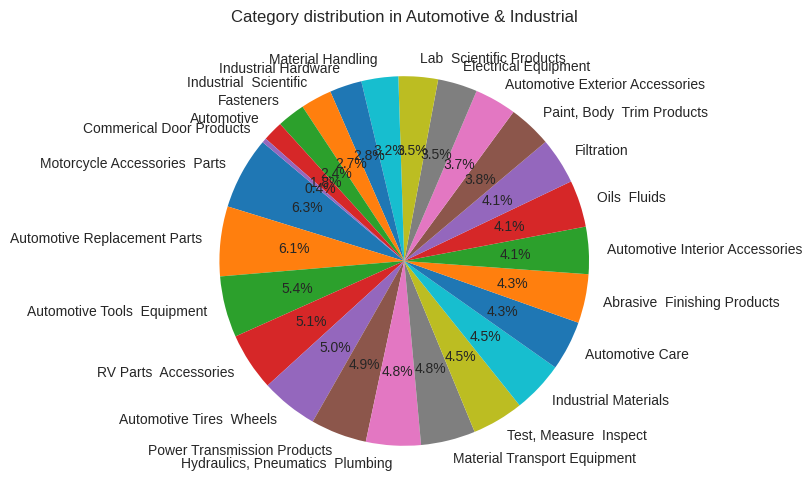

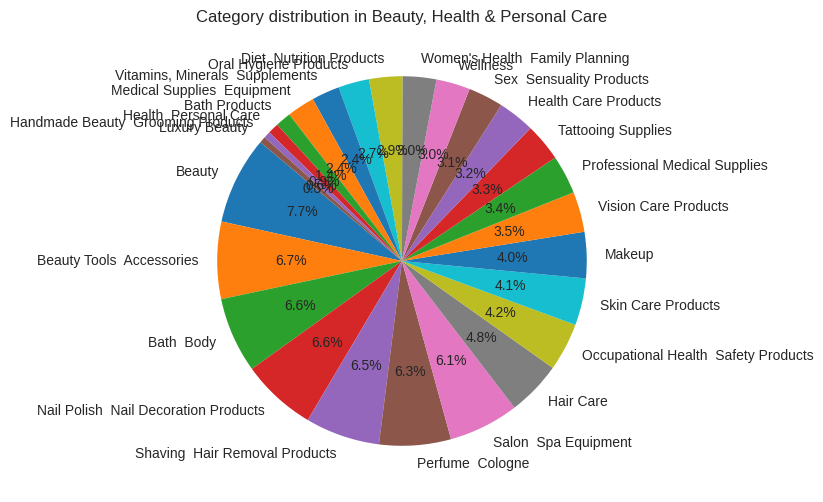

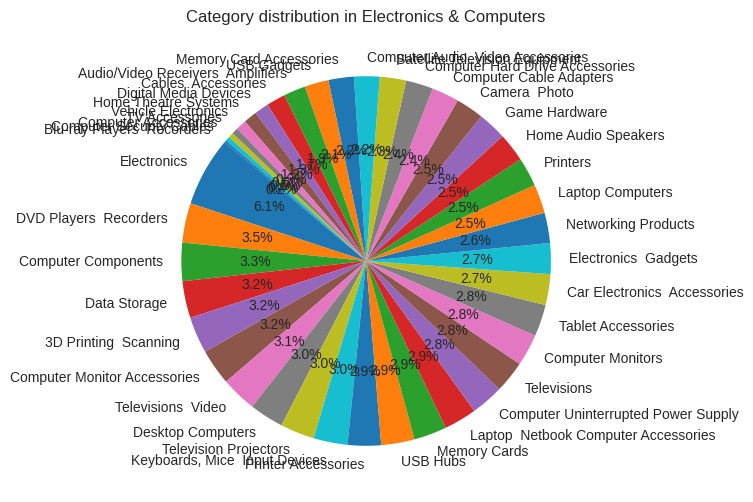

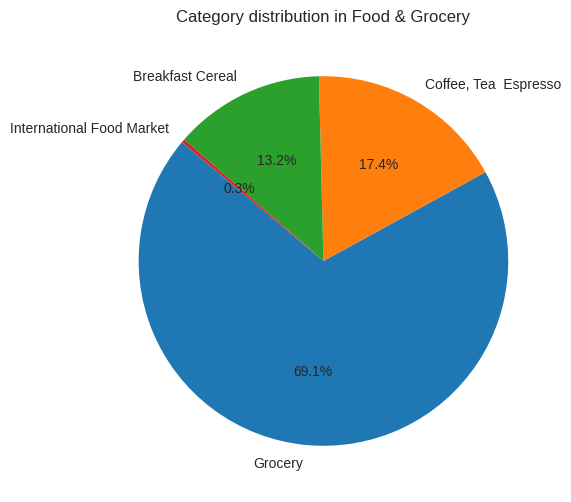

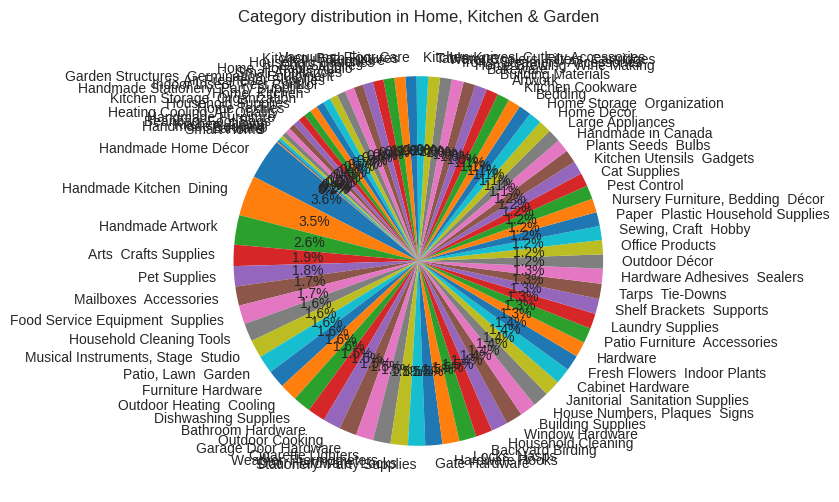

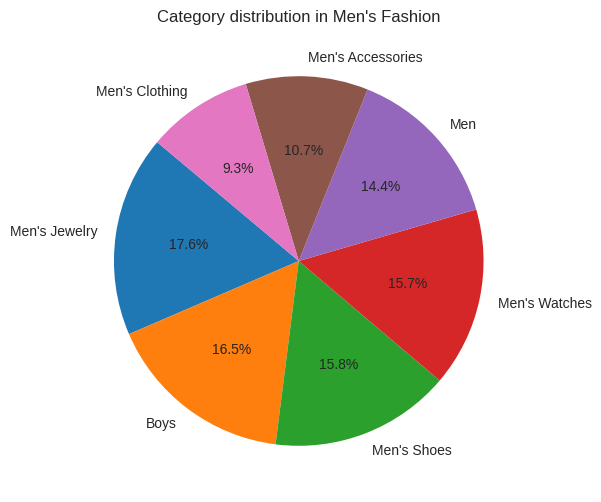

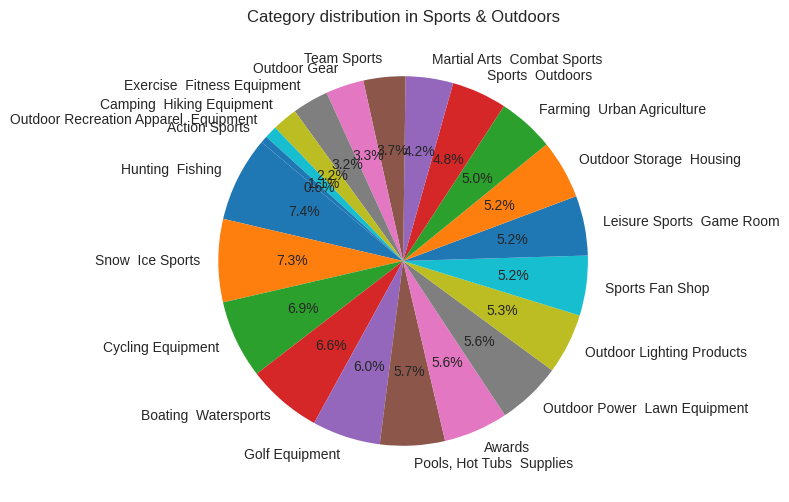

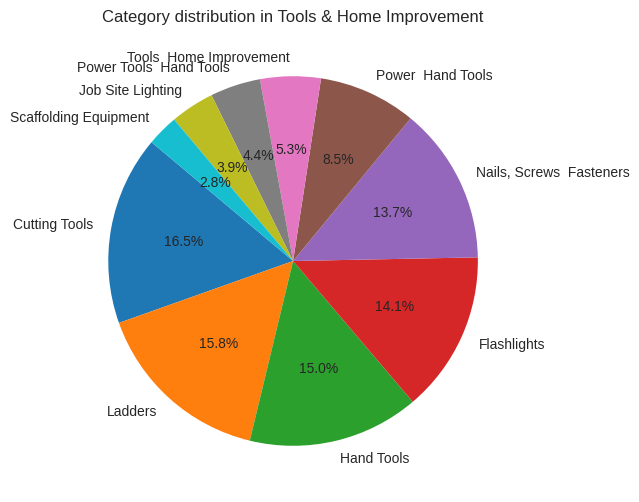

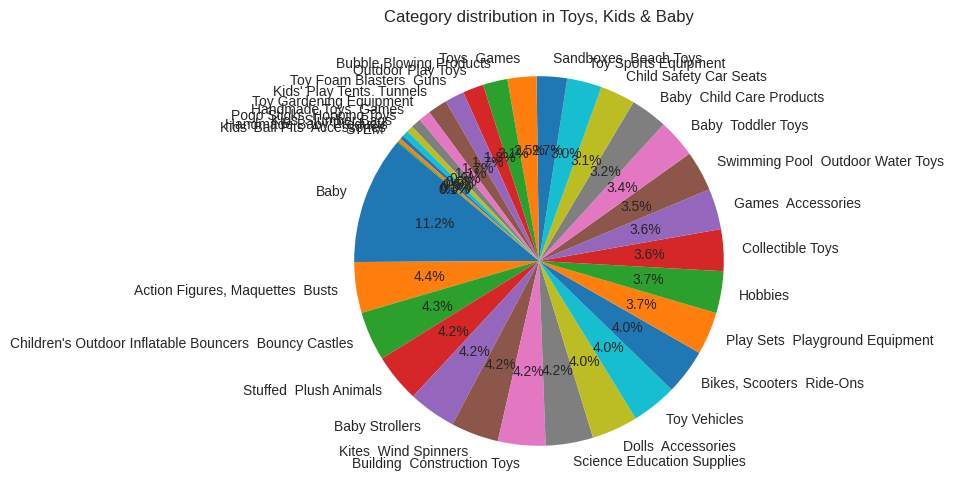

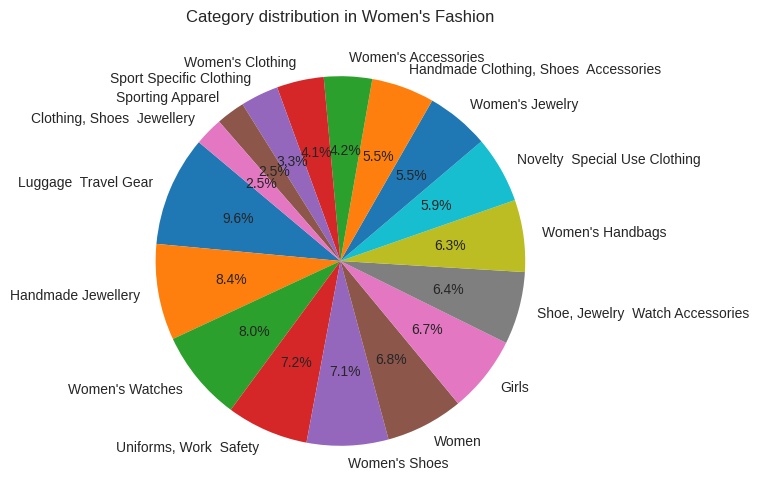

In [15]:
super_categories = category_counts['super_category'].unique()

for sc in super_categories:
    counts = category_counts[category_counts['super_category'] == sc]
    plt.figure(figsize=(6,6))
    plt.pie(counts['count'], labels=counts['categoryName'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Category distribution in {sc}')
    plt.show()


****as we can see there some equilibrium in the distrubution of each category giving the super category****

In [16]:
# Text Cleaning
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = " ".join([stemmer.stem(word) for word in text.split()])
    return text

df['clean_title'] = df['title'].apply(clean_text)
df['semantic_text'] = (
    df['clean_title'].fillna('') + " " + 
    df['categoryName'].fillna('') + " " +
    df['super_category'].fillna('')
).str.lower()

print(f"Sample semantic text:\n{df['semantic_text'].iloc[0][:100]}...")

Sample semantic text:
goofit 6coil magneto stator ignit gener for gy6 50cc 70cc 90cc 110cc 125cc mope atv dirt bike motorc...


In [17]:
# Quality Filtering 
MIN_REVIEWS = 20
df_filtered = df[df['reviews'] >= MIN_REVIEWS].copy()
print(f"After filtering (min {MIN_REVIEWS} reviews): {len(df_filtered):,} products")

After filtering (min 20 reviews): 83,989 products


## 4. Exploratory Data Analysis

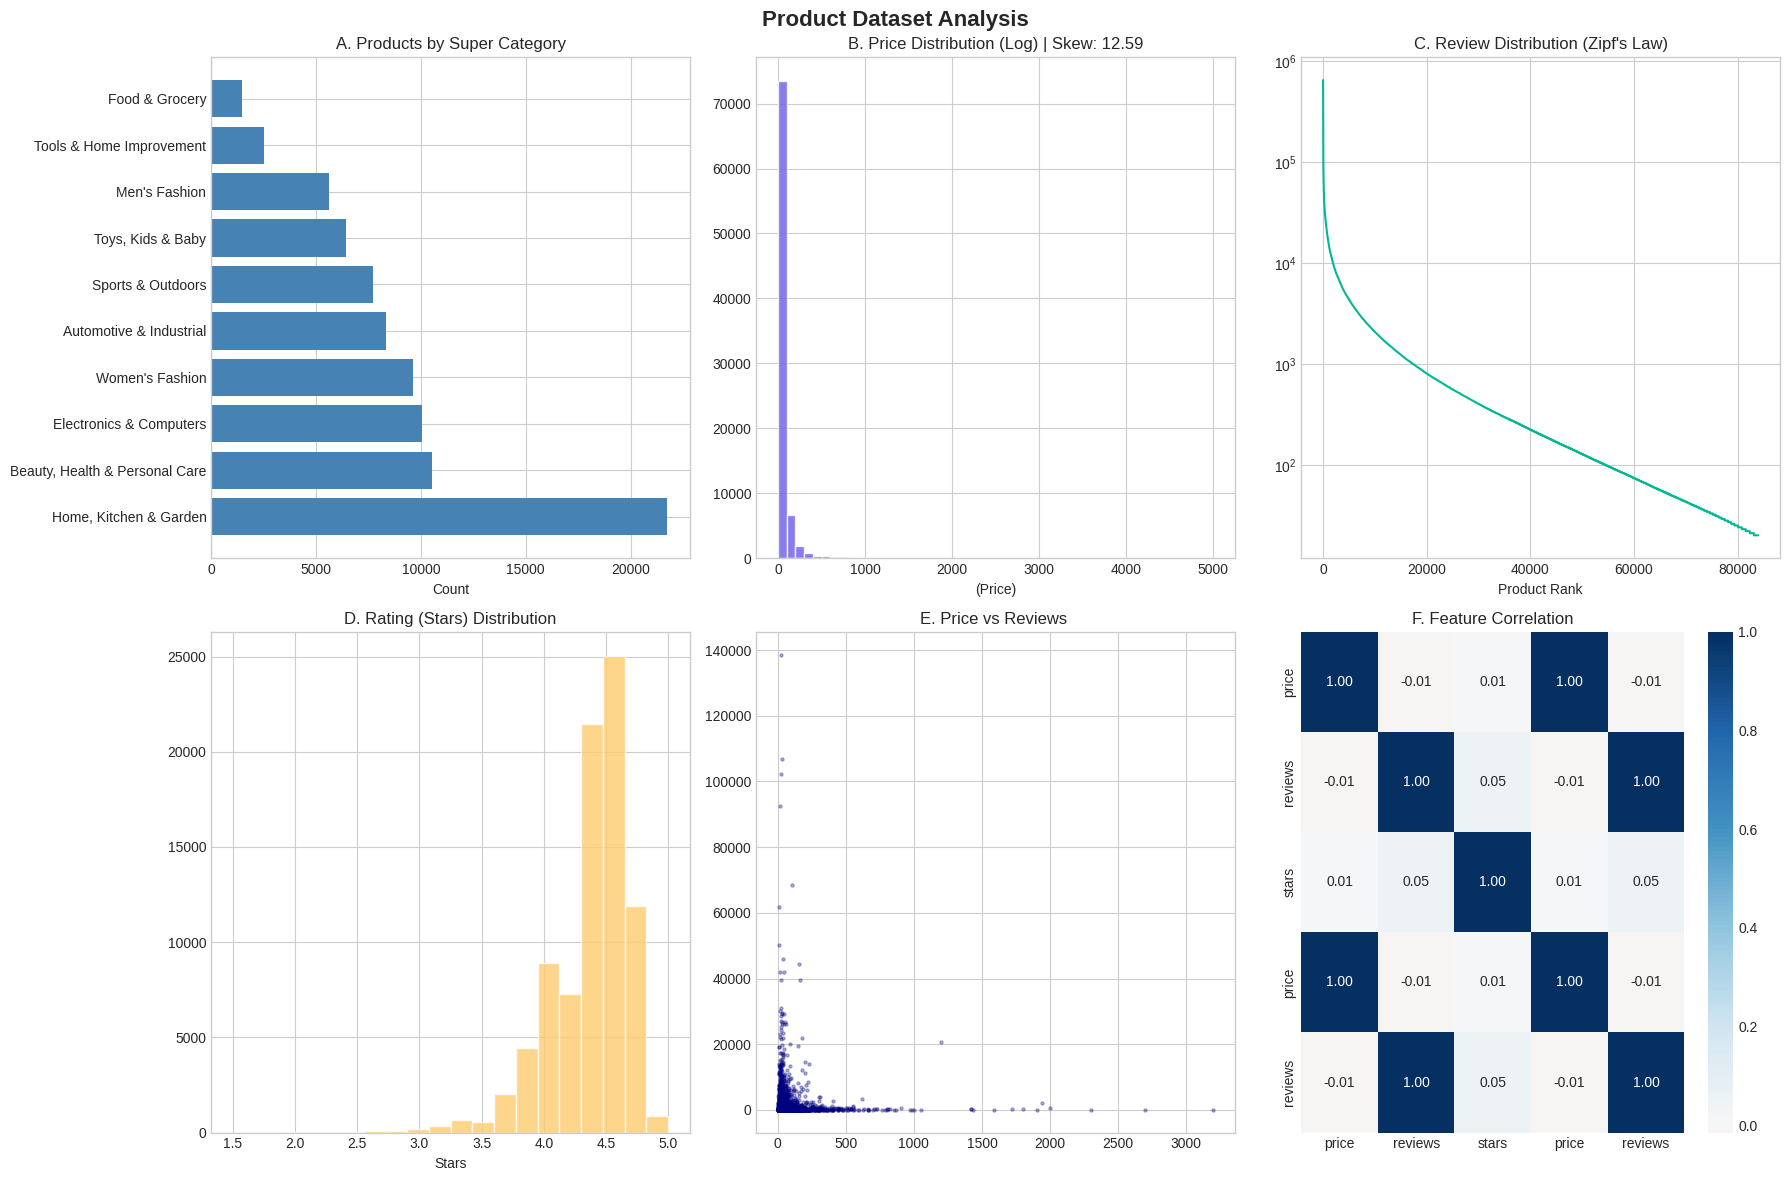

In [19]:
# Comprehensive EDA Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Product Dataset Analysis', fontsize=16, fontweight='bold')

# A. Category Distribution
cat_counts = df_filtered['super_category'].value_counts()
axes[0, 0].barh(cat_counts.index, cat_counts.values, color='steelblue')
axes[0, 0].set_title('A. Products by Super Category')
axes[0, 0].set_xlabel('Count')

# B. Price Distribution
axes[0, 1].hist(df_filtered['price'], bins=50, color='#6c5ce7', edgecolor='white', alpha=0.8)
axes[0, 1].set_title(f'B. Price Distribution (Log) | Skew: {df_filtered["price"].skew():.2f}')
axes[0, 1].set_xlabel('(Price)')

# C. Review Distribution 
sorted_reviews = df_filtered['reviews'].sort_values(ascending=False).reset_index(drop=True)
axes[0, 2].plot(sorted_reviews, color='#00b894', linewidth=1.5)
axes[0, 2].set_yscale('log')
axes[0, 2].set_title("C. Review Distribution (Zipf's Law)")
axes[0, 2].set_xlabel('Product Rank')

# D. Rating Distribution
axes[1, 0].hist(df_filtered['stars'], bins=20, color='#fdcb6e', edgecolor='white', alpha=0.8)
axes[1, 0].set_title('D. Rating (Stars) Distribution')
axes[1, 0].set_xlabel('Stars')

# E. Price vs Reviews
sample = df_filtered.sample(min(5000, len(df_filtered)), random_state=42)
axes[1, 1].scatter(sample['price'], sample['reviews'], alpha=0.3, s=5, c='navy')
axes[1, 1].set_title('E. Price vs Reviews ')


# F. Correlation Matrix
corr_cols = ['price', 'reviews', 'stars', 'price', 'reviews']
corr = df_filtered[corr_cols].corr()
sns.heatmap(corr, annot=True, cmap='RdBu', center=0, ax=axes[1, 2], fmt='.2f')
axes[1, 2].set_title('F. Feature Correlation')

plt.tight_layout()
plt.show()

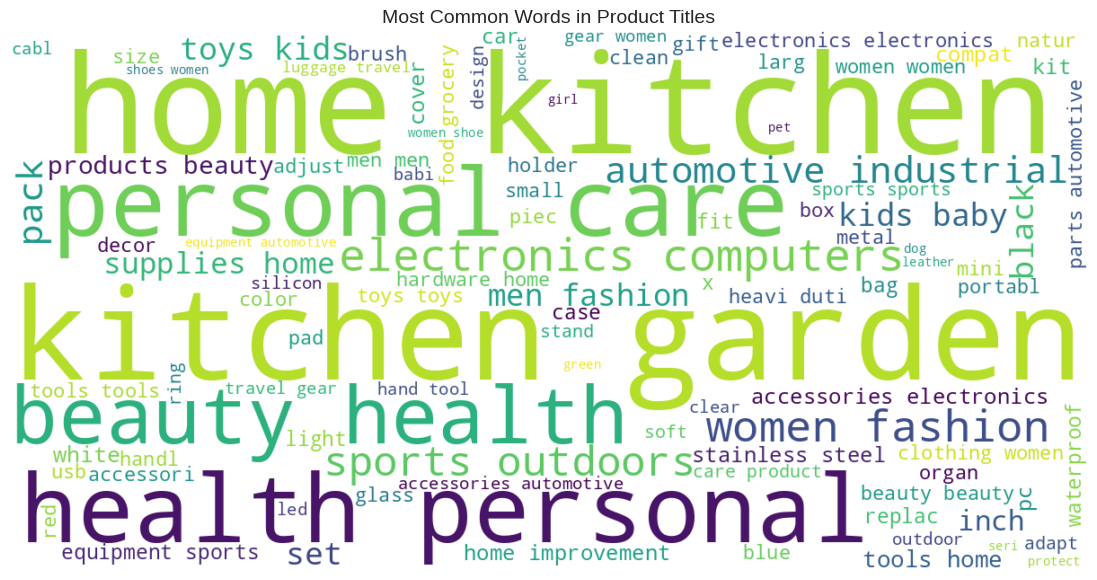

In [20]:
# Word Cloud Visualization
text_sample = " ".join(df_filtered['semantic_text'].sample(min(10000, len(df_filtered))).values)
wc = WordCloud(width=1200, height=600, background_color='white', 
               colormap='viridis', max_words=100).generate(text_sample)

plt.figure(figsize=(14, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Product Titles', fontsize=14)
plt.show()

****After visualisation , we can see that price review and stars wouldnt be good features for our training model , we will simply keep them for better search , thats all ****

## 5. Text Vectorization (TF-IDF)

In [21]:
# TF-IDF Vectorization
start = time.time()

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=25000,
    min_df=5,
    dtype=np.float32
)

tfidf_matrix = tfidf.fit_transform(df_filtered['semantic_text'])

print(f"Vectorization complete in {time.time() - start:.1f}s")
print(f"Matrix shape: {tfidf_matrix.shape[0]:,} products × {tfidf_matrix.shape[1]:,} features")

✅ Vectorization complete in 2.1s
Matrix shape: 83,989 products × 14,108 features


## 6. Product Clustering

In [22]:
# KMeans Clustering
N_CLUSTERS = 50

kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=42, batch_size=1024, n_init='auto')
df_filtered['cluster_id'] = kmeans.fit_predict(tfidf_matrix)

print(f" Created {N_CLUSTERS} product clusters")
print(f"Cluster distribution:\n{df_filtered['cluster_id'].value_counts().head(10)}")

✅ Created 50 product clusters
Cluster distribution:
cluster_id
43    10509
1      8627
11     6537
32     6438
2      5746
7      5724
16     4292
13     3628
3      2325
14     1941
Name: count, dtype: int64


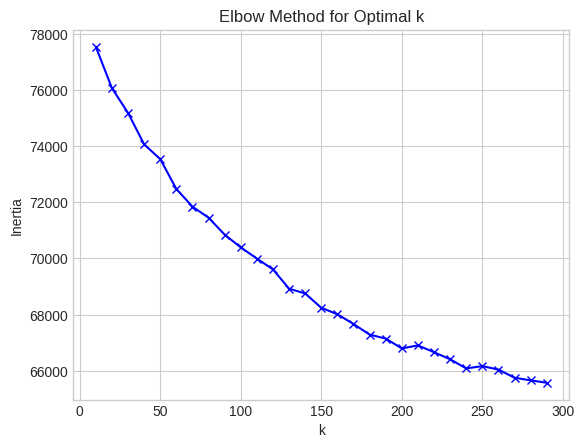

In [49]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

inertia = []
K_range = range(10, 300, 10) # Testing 40, 60, 80, 100, 120, 140 clusters

for k in K_range:
    km = MiniBatchKMeans(n_clusters=k, batch_size=2048, random_state=42)
    km.fit(tfidf_matrix)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

The mathematical optimal K is: 150


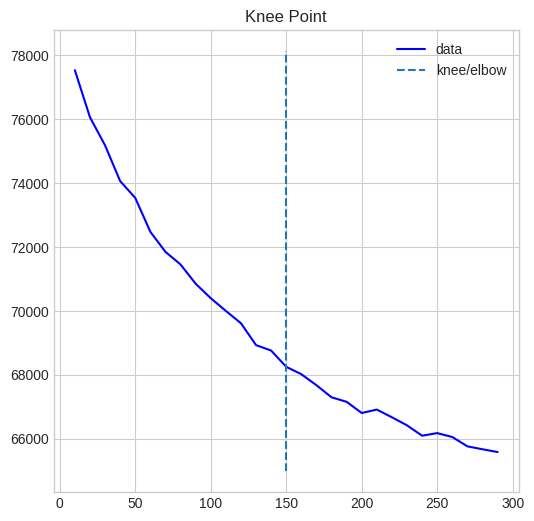

In [52]:
from kneed import KneeLocator
# Assuming you already ran the loop and have K_range and inertia lists
kl = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")

print(f"The mathematical optimal K is: {kl.elbow}")

# To see it on the graph:
kl.plot_knee()

In [53]:
# KMeans Clustering
N_CLUSTERS = 150

kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=42, batch_size=1024, n_init='auto')
df_filtered['cluster_id'] = kmeans.fit_predict(tfidf_matrix)

print(f" Created {N_CLUSTERS} product clusters")
print(f"Cluster distribution:\n{df_filtered['cluster_id'].value_counts().head(10)}")

 Created 150 product clusters
Cluster distribution:
cluster_id
115    6432
2      3993
28     3575
40     3297
6      3198
85     2955
3      2772
134    2231
1      1981
55     1364
Name: count, dtype: int64


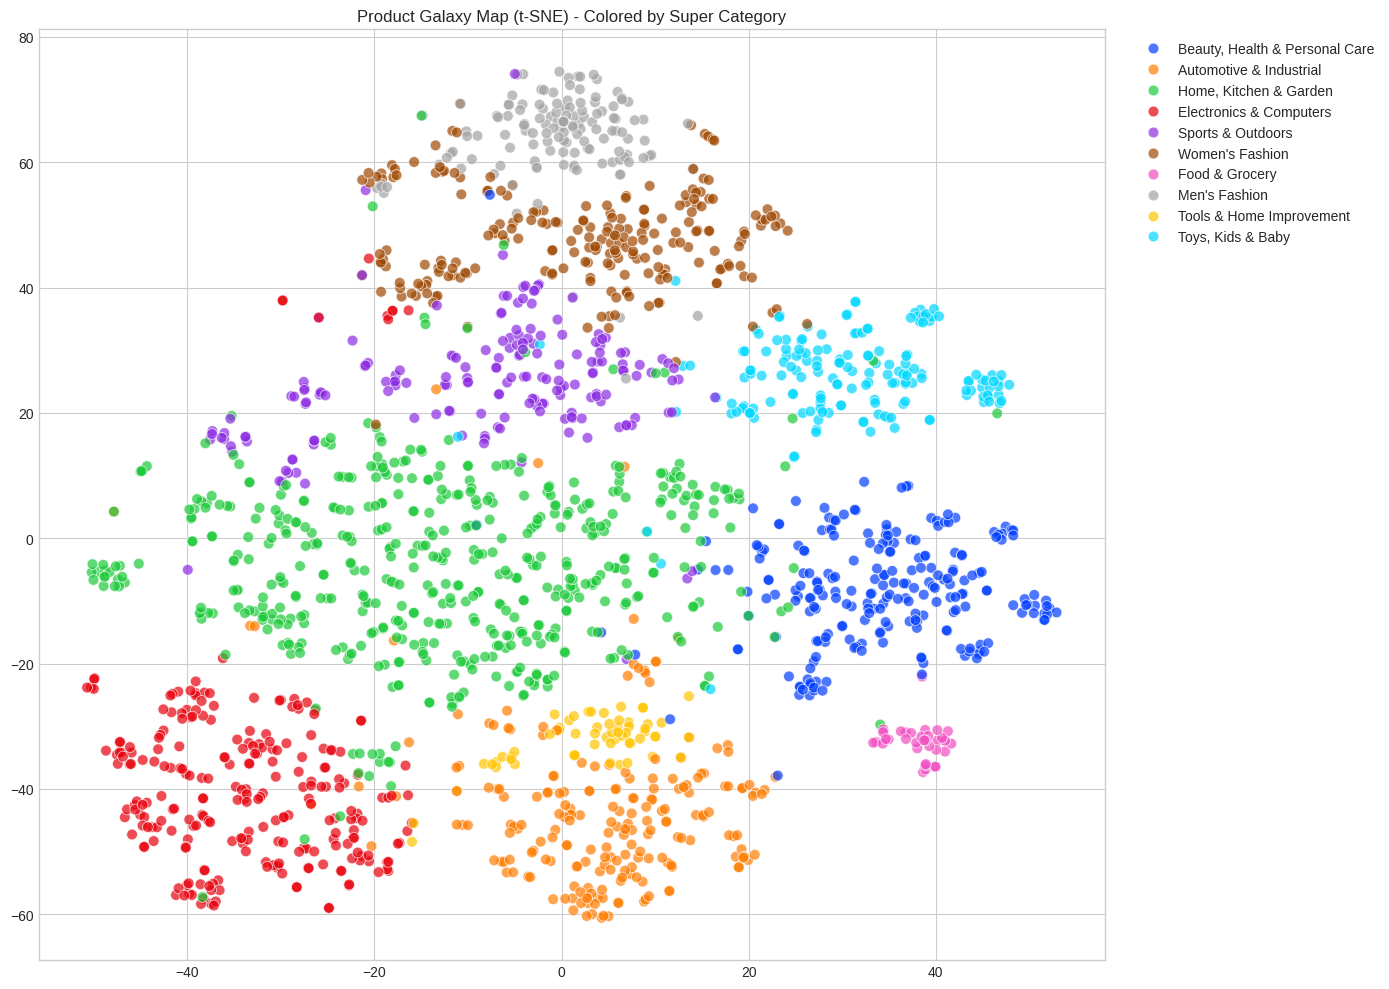

In [24]:
# t-SNE Visualization (2D projection)
SAMPLE_SIZE = 2000
sample_idx = np.random.choice(tfidf_matrix.shape[0], min(SAMPLE_SIZE, tfidf_matrix.shape[0]), replace=False)
sample_matrix = tfidf_matrix[sample_idx]
sample_labels = df_filtered.iloc[sample_idx]['super_category'].values

tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=42)
embedding = tsne.fit_transform(sample_matrix.toarray())

plt.figure(figsize=(14, 10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=sample_labels, palette='bright', s=60, alpha=0.7)
plt.title('Product Galaxy Map (t-SNE) - Colored by Super Category')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 7. Search Engine

In [25]:
# Build Search Engine
search_model = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute', n_jobs=-1)
search_model.fit(tfidf_matrix)
print(f"✅ Search engine ready ({tfidf_matrix.shape[0]:,} products indexed)")

✅ Search engine ready (83,989 products indexed)


In [26]:
def search(query, top_k=10, min_price=None, max_price=None, category=None):
    clean_q = clean_text(query)
    query_vec = tfidf.transform([clean_q])
    
    # 1. Get the predicted cluster
    predicted_cluster = kmeans.predict(query_vec)[0]
    
    # 2. Get KNN results (Retrieving 500 to have a good pool for filtering)
    distances, indices = search_model.kneighbors(query_vec, n_neighbors=min(500, len(df_filtered)))
    
    # 3. Create the results dataframe AND attach distances immediately
    results = df_filtered.iloc[indices[0]].copy()
    results['similarity'] = (1 - distances[0]) * 100  
    
    # 4. Apply the Cluster Filter
    cluster_results = results[results['cluster'] == predicted_cluster].copy()
    
    # 5. Fallback logic
    if not cluster_results.empty:
        results = cluster_results
    else:
        # If no cluster match, we keep the original 'results' (Global search)
        pass

    # 6. Apply UI Filters
    if min_price: results = results[results['price'] >= min_price]
    if max_price: results = results[results['price'] <= max_price]
    if category: results = results[results['super_category'] == category]
    
    if results.empty: return pd.DataFrame()
    
    # 7. Scoring
    results['star_score'] = results['stars'].rank(pct=True)
    results['review_score'] = np.log1p(results['reviews']).rank(pct=True)
    
    # Final Formula
    results['final_score'] = (results['similarity'] * 0.5) + (results['star_score'] * 30) + (results['review_score'] * 20)
    
    return results.sort_values('final_score', ascending=False).head(top_k)[
        ['title', 'price', 'stars', 'reviews', 'super_category', 'similarity']
    ]

In [27]:
# Test the Search Engine
display(search("Gaming Headset", max_price=100))

display(search("Wireless Mouse", category="Electronics & Computers"))

display(search("doll"))


 Testing: 'Gaming Headset' (max $100)


,title,price,stars,reviews,super_category,similarity
55373,"ASTRO Gaming A10 Gaming Headset, Red (PC)",50.00,4.3,24330,Electronics & Computers,60.309292
51243,"KANTUTOE RGB Gaming Headphone Stand, Gaming He...",24.66,4.5,58,Electronics & Computers,62.781082
67314,Corsair HS35 Stereo Gaming Headset,59.98,4.0,11316,Electronics & Computers,65.504692
43199,"Wireless Gaming Headset with Microphone, PHOIN...",52.99,4.1,544,Electronics & Computers,67.567146
120563,"Headphone Stand, Lamicall Headset Hanger Holde...",24.99,4.7,8172,"Home, Kitchen & Garden",40.530956
172955,Buffalo Games Chronology Board Game By-The Gam...,21.28,4.8,2996,"Toys, Kids & Baby",37.832462
139917,"DreamToyz Ring Toss Games for Adults, Yard Gam...",38.10,4.7,3261,Sports & Outdoors,36.233227
68834,Speedlink EXCELLO Illuminated Headset Stand - ...,66.00,4.5,34,Electronics & Computers,52.542805
170690,"Hasbro Gaming Battleship Classic Board Game, S...",17.99,4.7,2472,"Toys, Kids & Baby",33.195351
170093,BRAIN GAMES TEAM3 Green Board Game - A Thrilli...,34.17,4.8,145,"Toys, Kids & Baby",37.483536



 Testing: 'Wireless Mouse' (Electronics only)


,title,price,stars,reviews,super_category,similarity
54312,Dell KM7120W Keyboard & Mouse - Wireless Wirel...,99.00,4.4,367,Electronics & Computers,81.276443
69479,"memzuoix 2.4G Wireless Mouse, 1200 DPI Compute...",25.00,4.5,12328,Electronics & Computers,66.257950
53523,"Rii Wireless Mouse RM200, RGB Rechargeable Mou...",16.99,4.4,5911,Electronics & Computers,65.143272
55031,"Small Mouse Pad 6 x 8 Inch, Audimi Mini Mouse ...",9.99,4.6,3695,Electronics & Computers,57.538277
49117,"Rimilak Small Mouse Pad 6 x 7 Inch, Irregular ...",9.99,4.6,395,Electronics & Computers,56.833351
44126,Glorious RGB Mouse - Model O 67 g Ultralight H...,62.99,4.5,26812,Electronics & Computers,51.359589
64901,Logitech M220 Wireless Mouse,26.18,4.6,19003,Electronics & Computers,47.419487
59355,"TECKNET Wireless Computer Mouse, 2.4G Cordless...",16.99,4.5,2016,Electronics & Computers,54.404533
64884,Silicone Mouse Cover for Apple Magic Mouse I&I...,14.12,4.6,142,Electronics & Computers,56.187595
44204,"ITNRSIIET Mouse Pad with Non-Slip Rubber Base,...",10.89,4.6,4445,Electronics & Computers,47.453480


Testing: 'Gaming Headset'


,title,price,stars,reviews,super_category,similarity
55373,"ASTRO Gaming A10 Gaming Headset, Red (PC)",50.00,4.3,24330,Electronics & Computers,60.309292
51243,"KANTUTOE RGB Gaming Headphone Stand, Gaming He...",24.66,4.5,58,Electronics & Computers,62.781082
67314,Corsair HS35 Stereo Gaming Headset,59.98,4.0,11316,Electronics & Computers,65.504692
43199,"Wireless Gaming Headset with Microphone, PHOIN...",52.99,4.1,544,Electronics & Computers,67.567146
120563,"Headphone Stand, Lamicall Headset Hanger Holde...",24.99,4.7,8172,"Home, Kitchen & Garden",40.530956
172955,Buffalo Games Chronology Board Game By-The Gam...,21.28,4.8,2996,"Toys, Kids & Baby",37.832462
139917,"DreamToyz Ring Toss Games for Adults, Yard Gam...",38.10,4.7,3261,Sports & Outdoors,36.233227
68834,Speedlink EXCELLO Illuminated Headset Stand - ...,66.00,4.5,34,Electronics & Computers,52.542805
170690,"Hasbro Gaming Battleship Classic Board Game, S...",17.99,4.7,2472,"Toys, Kids & Baby",33.195351
170093,BRAIN GAMES TEAM3 Green Board Game - A Thrilli...,34.17,4.8,145,"Toys, Kids & Baby",37.483536


Testing: 'Wireless Mouse' (Electronics only)


,title,price,stars,reviews,super_category,similarity
54312,Dell KM7120W Keyboard & Mouse - Wireless Wirel...,99.00,4.4,367,Electronics & Computers,81.276443
69479,"memzuoix 2.4G Wireless Mouse, 1200 DPI Compute...",25.00,4.5,12328,Electronics & Computers,66.257950
53523,"Rii Wireless Mouse RM200, RGB Rechargeable Mou...",16.99,4.4,5911,Electronics & Computers,65.143272
55031,"Small Mouse Pad 6 x 8 Inch, Audimi Mini Mouse ...",9.99,4.6,3695,Electronics & Computers,57.538277
49117,"Rimilak Small Mouse Pad 6 x 7 Inch, Irregular ...",9.99,4.6,395,Electronics & Computers,56.833351
44126,Glorious RGB Mouse - Model O 67 g Ultralight H...,62.99,4.5,26812,Electronics & Computers,51.359589
64901,Logitech M220 Wireless Mouse,26.18,4.6,19003,Electronics & Computers,47.419487
59355,"TECKNET Wireless Computer Mouse, 2.4G Cordless...",16.99,4.5,2016,Electronics & Computers,54.404533
64884,Silicone Mouse Cover for Apple Magic Mouse I&I...,14.12,4.6,142,Electronics & Computers,56.187595
44204,"ITNRSIIET Mouse Pad with Non-Slip Rubber Base,...",10.89,4.6,4445,Electronics & Computers,47.453480


,title,price,stars,reviews,super_category,similarity
172270,"Barbie Careers Doll & Playset, Pediatrician Th...",27.99,4.8,1727,"Toys, Kids & Baby",64.716782
166522,Tender Leaf Toys - Sunny Doll Family - Set of ...,26.99,4.7,141,"Toys, Kids & Baby",63.104843
173102,Roll Over Image to Zoom in Glitter Girls Dolls...,32.99,4.6,2720,"Toys, Kids & Baby",60.542824
173866,HappyVk- Pink Baby Doll Diaper Bag with Doll C...,37.48,4.7,48,"Toys, Kids & Baby",64.937965
159275,Melissa & Doug Mine to Love Twins Luke & Lucy ...,69.99,4.8,10928,"Toys, Kids & Baby",46.581585
156797,Lifelike Reborn Baby Dolls - 18 inch Soft Body...,131.53,4.7,311,"Toys, Kids & Baby",55.509331
156082,84 Pack Doll Clothes and Accessories with Doll...,39.99,4.5,443,"Toys, Kids & Baby",63.287937
162791,Rakki Dolli Doll Clothes 3 Pc. Set Pink Grey P...,27.98,4.6,165,"Toys, Kids & Baby",61.668491
167284,Cave Club Bashley Doll (8 – 10-inch) Prehistor...,19.99,4.7,247,"Toys, Kids & Baby",55.314236
163502,Melissa & Doug Doll Feeding and Changing Acces...,50.48,4.7,3133,"Toys, Kids & Baby",49.675388


## 8. Model Evaluation

In [30]:
#Evaluation
def evaluate_recall(n_samples=100, k=10):
    sample_indices = np.random.choice(len(df_filtered), min(n_samples, len(df_filtered)), replace=False)
    hits, ranks = 0, []
    
    for idx in sample_indices:
        target = df_filtered.iloc[idx]
        query_vec = tfidf.transform([target['title'].lower()])
        _, indices = search_model.kneighbors(query_vec, n_neighbors=k+1)
        retrieved = df_filtered.iloc[indices[0]]['asin'].values
        
        if target['asin'] in retrieved:
            hits += 1
            rank = np.where(retrieved == target['asin'])[0][0] + 1
            ranks.append(1/rank)
        else:
            ranks.append(0)
    
    recall = (hits / len(sample_indices)) * 100
    mrr = np.mean(ranks)
    return recall, mrr

recall, mrr = evaluate_recall(n_samples=200)
print(f"Model Performance:")
print(f"Recall@10: {recall:.1f}%")
print(f"MRR: {mrr:.4f}")
print(f"Verdict: {' PASS' if recall > 80 else '⚠️ Needs Improvement'}")

Model Performance:
Recall@10: 94.5%
MRR: 0.8715
Verdict:  PASS


In [54]:
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np

def grid_search(df, param_grid, n_samples=50):
    """
    Evaluates combinations of Vectorization, Clustering, and Ranking Weights.
    """
    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    results_list = []
    print(f" Starting Grid Search: {len(combinations)} combinations to test.")

    for i, params in enumerate(combinations):
        print(f"Testing [{i+1}/{len(combinations)}]: Features={params['max_features']}, Clusters={params['n_clusters']}, Weights={params['weights']}")
        
        # 1. TF-IDF Step
        vectorizer = TfidfVectorizer(
            stop_words='english', 
            max_features=params['max_features'], 
            ngram_range=params['ngram_range'],
            use_idf=params['use_idf']
        )
        tfidf_matrix = vectorizer.fit_transform(df['title'].fillna(''))
        
        # 2. KMeans Step
        km = MiniBatchKMeans(n_clusters=params['n_clusters'], random_state=42, batch_size=2048)
        cluster_labels = km.fit_predict(tfidf_matrix)
        
        # 3. KNN Search Model Step
        knn = NearestNeighbors(metric='cosine', algorithm='brute')
        knn.fit(tfidf_matrix)
        
        # 4. Evaluation Step (Noisy Query Recall)
        hits = 0
        test_indices = np.random.choice(len(df), min(n_samples, len(df)), replace=False)
        
        w_sim, w_star, w_rev = params['weights']
        
        for idx in test_indices:
            target = df.iloc[idx]
            # SIMULATE REAL USER: Use only the first 3 words of the title
            query_text = " ".join(str(target['title']).split()[:3])
            query_vec = vectorizer.transform([query_text])
            
            # Get 50 candidates to allow ranking weights to do their job
            distances, indices = knn.kneighbors(query_vec, n_neighbors=50)
            candidates = df.iloc[indices[0]].copy()
            
            # Ranking Logic
            candidates['similarity'] = (1 - distances[0]) * 100
            candidates['star_score'] = candidates['stars'].rank(pct=True)
            candidates['rev_score'] = np.log1p(candidates['reviews']).rank(pct=True)
            
            # Apply Weights
            candidates['final'] = (candidates['similarity'] * w_sim) + \
                                 (candidates['star_score'] * w_star) + \
                                 (candidates['rev_score'] * w_rev)
            
            # Check if correct ASIN is in Top 10 survivors
            top_10 = candidates.sort_values('final', ascending=False).head(10)
            if target['asin'] in top_10['asin'].values:
                hits += 1
        
        recall = (hits / n_samples) * 100
        
        # Store result
        res = params.copy()
        res['recall_at_10'] = recall
        results_list.append(res)

    return pd.DataFrame(results_list).sort_values('recall_at_10', ascending=False)

# --- HOW TO RUN ---
params_to_test = {
    'max_features': [10000, 15000],
    'ngram_range': [(1, 1), (1, 2)],   # Single words vs Phrases
    'use_idf': [True],
    'n_clusters': [80, 120, 150],      # Guided by your Elbow Plot
    'weights': [
        (0.7, 20, 10),  # Relevance Bias
        (0.5, 30, 20),  # Quality/Popularity Bias
        (0.8, 10, 10)   # Strict Similarity Bias
    ]
}

# Run with a small sample first to save time
leaderboard = grid_search(df_filtered, params_to_test, n_samples=30)
display(leaderboard.head(10))

🚀 Starting Grid Search: 36 combinations to test.
Testing [1/36]: Features=10000, Clusters=80, Weights=(0.7, 20, 10)
Testing [2/36]: Features=10000, Clusters=80, Weights=(0.5, 30, 20)
Testing [3/36]: Features=10000, Clusters=80, Weights=(0.8, 10, 10)
Testing [4/36]: Features=10000, Clusters=120, Weights=(0.7, 20, 10)
Testing [5/36]: Features=10000, Clusters=120, Weights=(0.5, 30, 20)
Testing [6/36]: Features=10000, Clusters=120, Weights=(0.8, 10, 10)
Testing [7/36]: Features=10000, Clusters=150, Weights=(0.7, 20, 10)
Testing [8/36]: Features=10000, Clusters=150, Weights=(0.5, 30, 20)
Testing [9/36]: Features=10000, Clusters=150, Weights=(0.8, 10, 10)
Testing [10/36]: Features=10000, Clusters=80, Weights=(0.7, 20, 10)
Testing [11/36]: Features=10000, Clusters=80, Weights=(0.5, 30, 20)
Testing [12/36]: Features=10000, Clusters=80, Weights=(0.8, 10, 10)
Testing [13/36]: Features=10000, Clusters=120, Weights=(0.7, 20, 10)
Testing [14/36]: Features=10000, Clusters=120, Weights=(0.5, 30, 20)


,max_features,ngram_range,use_idf,n_clusters,weights,recall_at_10
23,15000,"(1, 1)",True,120,"(0.8, 10, 10)",73.333333
24,15000,"(1, 1)",True,150,"(0.7, 20, 10)",73.333333
20,15000,"(1, 1)",True,80,"(0.8, 10, 10)",63.333333
2,10000,"(1, 1)",True,80,"(0.8, 10, 10)",60.000000
32,15000,"(1, 2)",True,120,"(0.8, 10, 10)",60.000000
5,10000,"(1, 1)",True,120,"(0.8, 10, 10)",60.000000
8,10000,"(1, 1)",True,150,"(0.8, 10, 10)",56.666667
0,10000,"(1, 1)",True,80,"(0.7, 20, 10)",53.333333
31,15000,"(1, 2)",True,120,"(0.5, 30, 20)",53.333333
3,10000,"(1, 1)",True,120,"(0.7, 20, 10)",53.333333


## 9. Save Artifacts

In [66]:
# 1. Extract the best parameters from the top of your leaderboard
# We convert it to a dictionary so it's easier to read than a list
best_params = leaderboard.iloc[0].to_dict()

def build_final_model(p):
    """
    Takes the best parameters and builds the optimized pipeline.
    """
    print(f" Building Final Model with {p['max_features']} features and {p['n_clusters']} clusters...")
    
    # Declare globals so the search function can find them
    global tfidf, kmeans, search_model, final_weights
    
    # Step A: Optimized TF-IDF
    tfidf = TfidfVectorizer(
        stop_words='english',
        max_features=int(p['max_features']),
        ngram_range=p['ngram_range'],
        use_idf=p['use_idf']
    )
    tfidf_matrix = tfidf.fit_transform(df_filtered['title'].fillna(''))
    
    # Step B: Optimized KMeans
    kmeans = MiniBatchKMeans(
        n_clusters=int(p['n_clusters']), 
        random_state=42, 
        batch_size=2048
    )
    df_filtered['cluster'] = kmeans.fit_predict(tfidf_matrix)
    
    # Step C: Optimized KNN Search Model
    search_model = NearestNeighbors(metric='cosine', algorithm='brute')
    search_model.fit(tfidf_matrix)
    
    # Step D: Store the winning weights
    final_weights = p['weights']
    
    print("Model build complete! You can now use the search() function.")

# Step 2: Run the builder
build_final_model(best_params)

# Step 3: Define the Final Search Function
def search(query, top_k=10, min_price=None, max_price=None, category=None):
    clean_q = clean_text(query)
    query_vec = tfidf.transform([clean_q])
    
    # 1. Cluster Prediction
    predicted_cluster = kmeans.predict(query_vec)[0]
    
    # 2. KNN Retrieval (Get 500 candidates)
    distances, indices = search_model.kneighbors(query_vec, n_neighbors=min(500, len(df_filtered)))
    results = df_filtered.iloc[indices[0]].copy()
    results['similarity'] = (1 - distances[0]) * 100
    
    # 3. Cluster Filtering (Stay in the same group)
    cluster_match = results[results['cluster'] == predicted_cluster].copy()
    if not cluster_match.empty:
        results = cluster_match
    
    # 4. Standard Filters
    if min_price: results = results[results['price'] >= min_price]
    if max_price: results = results[results['price'] <= max_price]
    if category: results = results[results['super_category'] == category]
    
    if results.empty: return pd.DataFrame()
    
    # 5. Scoring with Optimized Weights from Grid Search
    results['star_score'] = results['stars'].rank(pct=True)
    results['review_score'] = np.log1p(results['reviews']).rank(pct=True)
    
    w_sim, w_star, w_rev = final_weights
    results['final_score'] = (results['similarity'] * w_sim) + \
                             (results['star_score'] * w_star) + \
                             (results['review_score'] * w_rev)
    
    return results.sort_values('final_score', ascending=False).head(top_k)[
        ['title', 'price', 'stars', 'reviews', 'super_category', 'similarity']
    ]

🛠️ Building Final Model with 15000 features and 120 clusters...
✅ Model build complete! You can now use the search() function.


In [ ]:
artifacts = {
    'data': df_filtered,
    'embeddings': tfidf_matrix,
    'vectorizer': tfidf,
    'search_model': search_model,
    'kmeans_model': kmeans
}
joblib.dump(artifacts, 'recommendation_engine.pkl')
print(" Model saved!")